In [3]:
# 일반적인 패키지 불러오기
import numpy as np
import pandas as pd
import json
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# scikit-learn 패키지 불러오기
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# pytorch 패키지 가져오기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [4]:
#%pwd

In [5]:
# import sys

# # 본 코드가 실행되는 환경이 KAGGLE인 경우 True로
# # 로컬 PC인 경우 False로 설정하면 된다.
# KAGGLE = True

# if KAGGLE==True:
#     package_path = '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'
#     sys.path.append(package_path)    
# else:
#     package_path = '/home/park/VisionEx/efficientnet_pytorch/EfficientNet-PyTorch-master'
#     sys.path.append(package_path)        


In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

OUTPUT_DIR = './'

TRAIN_DIR = '/content/drive/MyDrive/Kaggle/COVID_X-RAY/train'
TEST_DIR = '/content/drive/MyDrive/Kaggle/COVID_X-RAY/test'

In [7]:
#labels = pd.read_csv('/content/drive/MyDrive/Kaggle/COVID_X-RAY/train/labels.csv')
train = pd.read_csv('/content/drive/MyDrive/Kaggle/COVID_X-RAY/labels.csv')
# 정답지를 제출하는 csv파일
sample = pd.read_csv('/content/drive/MyDrive/Kaggle/COVID_X-RAY/submission.csv')    
    
X, Y = train['filename'].values, train['label'].values
X_test = [name for name in (os.listdir(TEST_DIR))]

In [8]:
# 이미지파일명, 레이블을 저장하고 있는 데이터프레임
train.head()

,filename,label
0,image_001.png,covid
1,image_002.png,covid
2,image_003.png,normal
3,image_004.png,normal
4,image_005.png,normal


In [9]:
SEED=777    
BATCH = 32
EPOCHS = 35
LR = 0.001 #0.0001
IM_SIZE = 200 #256
N_FOLD=5

TARGET_COL='label'    
MODELNAME='efficientnet-b0'

In [10]:
# train 데이터프레임을 물리적으로 복사
# folds라는 데이터프레임 생성
folds = train.copy()

Fold = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[TARGET_COL])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [11]:
# Train 데이터셋을 위한 클래스를 생성
class TrainData(Dataset):
    def __init__(self, Dir, FNames, Labels, Transform):
        self.dir = Dir
        self.fnames = FNames
        self.transform = Transform
        self.lbs = Labels
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):
        x = Image.open(os.path.join(self.dir, self.fnames[index])).convert('RGB')
        return self.transform(x), self.lbs[index] 

# Test 데이터셋을 위한 클래스를 생성    
class TestData(Dataset):
    def __init__(self, Dir, FNames, Transform):
        self.dir = Dir
        self.fnames = FNames
        self.transform = Transform
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):
        x = Image.open(os.path.join(self.dir, self.fnames[index])).convert('RGB')   
        return self.transform(x), self.fnames[index]

In [12]:
# 데이터 전처리 + 데이터 증식
train_transform = transforms.Compose(
    [transforms.RandomResizedCrop((IM_SIZE, IM_SIZE), scale=(0.8, 1.0)),
     #transforms.Grayscale(num_output_channels=3),
     transforms.RandomRotation(30),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1, hue=0),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
     #transforms.Normalize((0.485), (0.229))
    ])

# 데이터 전처리 (Validation과 test데이터는 데이터 증식X)
test_transform = transforms.Compose(
    [transforms.Resize((IM_SIZE, IM_SIZE)),
     #transforms.Grayscale(num_output_channels=3),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
     #transforms.Normalize((0.485), (0.229))
    ])

In [13]:
def one_hot(Y):
  # one-hot -> to tensor

  labels = torch.zeros(size=(len(Y),1))
  for idx, label in enumerate(Y):
    if label=='covid':
     labels[idx] = True
    else:
      labels[idx] = False

  return labels

In [14]:
True == 0

False

In [15]:
# StratifyKFold를 이용해서 validation 데이터셋으로 나눠준다.
trn_idx = folds[folds['fold'] != 0].index
val_idx = folds[folds['fold'] == 0].index

X_train, Y_train = X[trn_idx], Y[trn_idx]
X_val, Y_val = X[val_idx], Y[val_idx]

trainset = TrainData(TRAIN_DIR, X_train, one_hot(Y_train), train_transform)
trainloader = DataLoader(trainset,
                         batch_size=BATCH,
                         shuffle=True)

validset = TrainData(TRAIN_DIR, X_val, one_hot(Y_val), test_transform)
validloader = DataLoader(validset,
                         batch_size=BATCH,
                         shuffle=False)

testset = TestData(TEST_DIR, X_test, test_transform)
testloader = DataLoader(testset,
                        batch_size=BATCH,
                        shuffle=False)

# for batch_idx, (images, labels) in enumerate(trainloader,0):
#         # BATCH=32로 경사하강법 1걸음 이동
#         print(images, labels)

# labels = torch.zeros(size=(len(Y),1))
# for idx, label in enumerate(Y):
#   if label=='covid':
#     labels[idx] = True
#   else:
#     labels[idx] = False
# labels

In [16]:
!pip install efficientnet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=ae145e68cc166686d1d8c1173cd6b0f799127a360c9b97cd44bca0864f776098
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet-pytorch


In [17]:
from efficientnet_pytorch import EfficientNet

# 모델 생성을 위한 클래스
class enetv2(nn.Module):
    def __init__(self, out_dim=1, ModelName="efficientnet-b0"):
        super(enetv2, self).__init__()
        # 전이학습 모델을 가져오기
        self.basemodel = EfficientNet.from_name(MODELNAME)
        # 특징 추출기의 파라메터는 학습하지 않게 설정
        for param in self.basemodel.parameters():
            param.requires_grad = False
        # 분류기
        self.myfc = nn.Linear(self.basemodel._fc.in_features, out_dim)
        self.basemodel._fc = nn.Identity()        
            
    def extract(self, x):
        return self.basemodel(x)

    # 추론
    def forward(self, x):
        x = self.basemodel(x)
        x = self.myfc(x)
        return x

In [18]:
from efficientnet_pytorch import EfficientNet

class CovidNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model = EfficientNet.from_pretrained(MODELNAME, in_channels=3) 
        num_in_features = self.model._fc.in_features
        print(num_in_features)
        self.model._fc = nn.Linear(num_in_features, 1)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
model = CovidNet()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 57.1MB/s]


Loaded pretrained weights for efficientnet-b0
1280


In [19]:
#EfficientNet Model 생성
#model = enetv2(1, MODELNAME)
# 파라메터 값 가져오기
#checkpoint = torch.load("/content/drive/MyDrive/Kaggle/COVID_X-RAY/checkpoint", map_location=DEVICE)    
#model.load_state_dict(checkpoint, strict=False)

# Model을 GPU에 로딩
model = model.to(DEVICE)

# Loss함수, optimizer, sceduler정의
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss().to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True)
#criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [20]:
from tqdm import tqdm

def train(model, train_loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    # 1 epoch
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader),0):
        # BATCH=32로 경사하강법 1걸음 이동
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad() 
        outputs = model(images)
        
        loss = criterion(outputs, labels)
    
        
        running_loss += loss.item()
        #_, predict = torch.max(outputs.data, 1)
        predict = torch.sigmoid(outputs)
        predict = torch.where(predict > 0.5, 1, 0 )
        correct += torch.sum( predict == labels ).item()
        total += labels.size(0)

        loss.backward()
        optimizer.step()
        
    train_loss = running_loss / total
    train_acc = correct / total
    #train_acc = correct / len(train_loader.data)
    
    return train_loss, train_acc

def valid(model, valid_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    # 파라메터를 업데이트 하지 않는다.
    with torch.no_grad():
        
        for batch_idx, (images, labels) in enumerate(valid_loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            #_, predict = torch.max(outputs.data, 1)
            predict = torch.sigmoid(outputs)
            predict = torch.where(predict > 0.5, 1, 0 )
            correct += (predict == labels).sum().item()
            total += labels.size(0)
            
    val_loss = running_loss / len(valid_loader)
    val_acc = correct / total
    
    return val_loss, val_acc

In [21]:
OUTPUT_DIR = './'

best_score = 0.

for epoch_idx in range(EPOCHS):

    train_loss, train_acc = train(model, trainloader)
    valid_loss, valid_acc = valid(model, validloader)
    
    # model save
    if valid_acc > best_score:
        best_score = valid_acc

        torch.save({'model': model.state_dict()},
                    OUTPUT_DIR+f'{MODELNAME}_best.pth')
        
        print('model saved')
        
    # rl scheduler
    scheduler.step(valid_loss)

    print('Epoch: {} |train_loss: {:.3f} valid loss: {:.3f} train_acc: {:.3f} valid_acc: {:.3f}'.format(epoch_idx, train_loss, valid_loss, train_acc, valid_acc))

100%|██████████| 50/50 [12:25<00:00, 14.90s/it]
/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


model saved
Epoch: 0 |train_loss: 0.014 valid loss: 1.064 train_acc: 0.806 valid_acc: 0.608


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


model saved
Epoch: 1 |train_loss: 0.009 valid loss: 0.382 train_acc: 0.886 valid_acc: 0.873


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


model saved
Epoch: 2 |train_loss: 0.007 valid loss: 0.324 train_acc: 0.909 valid_acc: 0.885


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Epoch: 3 |train_loss: 0.007 valid loss: 0.435 train_acc: 0.908 valid_acc: 0.855


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


model saved
Epoch: 4 |train_loss: 0.007 valid loss: 0.317 train_acc: 0.911 valid_acc: 0.895


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Epoch: 5 |train_loss: 0.005 valid loss: 0.805 train_acc: 0.926 valid_acc: 0.868


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


model saved
Epoch: 6 |train_loss: 0.006 valid loss: 0.157 train_acc: 0.927 valid_acc: 0.950


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


model saved
Epoch: 7 |train_loss: 0.004 valid loss: 0.097 train_acc: 0.946 valid_acc: 0.968


100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


Epoch: 8 |train_loss: 0.005 valid loss: 0.233 train_acc: 0.936 valid_acc: 0.925


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Epoch: 9 |train_loss: 0.004 valid loss: 0.137 train_acc: 0.952 valid_acc: 0.958


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Epoch: 10 |train_loss: 0.004 valid loss: 0.401 train_acc: 0.951 valid_acc: 0.863


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Epoch: 11 |train_loss: 0.004 valid loss: 0.116 train_acc: 0.954 valid_acc: 0.963


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Epoch: 12 |train_loss: 0.004 valid loss: 0.121 train_acc: 0.961 valid_acc: 0.960


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


Epoch: 13 |train_loss: 0.004 valid loss: 0.234 train_acc: 0.958 valid_acc: 0.938


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


Epoch: 14 |train_loss: 0.004 valid loss: 0.157 train_acc: 0.952 valid_acc: 0.925


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Epoch: 15 |train_loss: 0.004 valid loss: 0.170 train_acc: 0.958 valid_acc: 0.955


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Epoch: 16 |train_loss: 0.003 valid loss: 0.147 train_acc: 0.973 valid_acc: 0.965


100%|██████████| 50/50 [00:15<00:00,  3.26it/s]


Epoch: 17 |train_loss: 0.003 valid loss: 0.144 train_acc: 0.964 valid_acc: 0.958


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Epoch: 18 |train_loss: 0.003 valid loss: 0.117 train_acc: 0.966 valid_acc: 0.963


100%|██████████| 50/50 [00:15<00:00,  3.27it/s]


model saved
Epoch: 19 |train_loss: 0.003 valid loss: 0.077 train_acc: 0.965 valid_acc: 0.980


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


Epoch: 20 |train_loss: 0.003 valid loss: 0.225 train_acc: 0.961 valid_acc: 0.915


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


Epoch: 21 |train_loss: 0.003 valid loss: 0.103 train_acc: 0.971 valid_acc: 0.973


100%|██████████| 50/50 [00:15<00:00,  3.29it/s]


Epoch: 22 |train_loss: 0.004 valid loss: 0.125 train_acc: 0.966 valid_acc: 0.963


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


Epoch: 23 |train_loss: 0.003 valid loss: 0.178 train_acc: 0.964 valid_acc: 0.935


100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


Epoch: 24 |train_loss: 0.003 valid loss: 0.273 train_acc: 0.958 valid_acc: 0.915


100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


Epoch: 25 |train_loss: 0.002 valid loss: 0.100 train_acc: 0.971 valid_acc: 0.963


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Epoch: 26 |train_loss: 0.002 valid loss: 0.221 train_acc: 0.974 valid_acc: 0.925


100%|██████████| 50/50 [00:15<00:00,  3.30it/s]


Epoch: 27 |train_loss: 0.003 valid loss: 0.122 train_acc: 0.971 valid_acc: 0.970


100%|██████████| 50/50 [00:15<00:00,  3.27it/s]


model saved
Epoch: 28 |train_loss: 0.001 valid loss: 0.046 train_acc: 0.988 valid_acc: 0.993


100%|██████████| 50/50 [00:15<00:00,  3.29it/s]


Epoch: 29 |train_loss: 0.002 valid loss: 0.100 train_acc: 0.979 valid_acc: 0.970


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Epoch: 30 |train_loss: 0.002 valid loss: 0.053 train_acc: 0.977 valid_acc: 0.978


100%|██████████| 50/50 [00:15<00:00,  3.25it/s]


Epoch: 31 |train_loss: 0.002 valid loss: 0.205 train_acc: 0.973 valid_acc: 0.945


100%|██████████| 50/50 [00:15<00:00,  3.30it/s]


Epoch: 32 |train_loss: 0.002 valid loss: 0.100 train_acc: 0.978 valid_acc: 0.968


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Epoch: 33 |train_loss: 0.002 valid loss: 0.241 train_acc: 0.979 valid_acc: 0.945


100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


Epoch: 34 |train_loss: 0.003 valid loss: 0.143 train_acc: 0.968 valid_acc: 0.970


In [92]:
model.load_state_dict(torch.load(OUTPUT_DIR+f'{MODELNAME}_best.pth'), strict=False)
s_ls = []

# Test 데이터로 Test를 실행 
with torch.no_grad():
    model.eval()
    for image, fname in testloader: 
        image = image.to(DEVICE)
        
        logits = model(image)        
        ps = torch.sigmoid(logits) 
        ps = torch.where(ps > 0.5, 1, 0 )   
        
        for i, pred in enumerate(ps):
            s_ls.append([fname[i], pred.item()])

In [101]:
# csv파일에 결과를 적는다 (kaggle에 제출하기 위해)
# print(ps)
# print(s_ls)
# sub = np.array(s_ls).T[1]
# sub = np.where(sub['label'] == '0', "normal", "covid")
sub = pd.DataFrame.from_records(s_ls, columns=['filename', 'label'])
sub.loc[sub['label']==0,'label'] = 'normal'
sub.loc[sub['label']==1,'label'] = 'covid'
sub = sub.sort_values(by=['filename'])
print(sub)
sub.to_csv("/content/drive/MyDrive/Kaggle/COVID_X-RAY/submission.csv", index=False)

          filename   label
42   image_001.png   covid
121  image_002.png   covid
265  image_003.png  normal
54   image_004.png   covid
247  image_005.png  normal
..             ...     ...
27   image_396.png  normal
387  image_397.png  normal
335  image_398.png  normal
81   image_399.png  normal
210  image_400.png  normal

[400 rows x 2 columns]


In [94]:
sub.head()

,filename,label
0,image_300.png,covid
1,image_131.png,normal
2,image_104.png,covid
3,image_293.png,covid
4,image_274.png,normal


In [95]:
def get_checkpoint(folder, checkpoint_name):
    checkpoint_path = os.path.join(folder, checkpoint_name)
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    return checkpoint

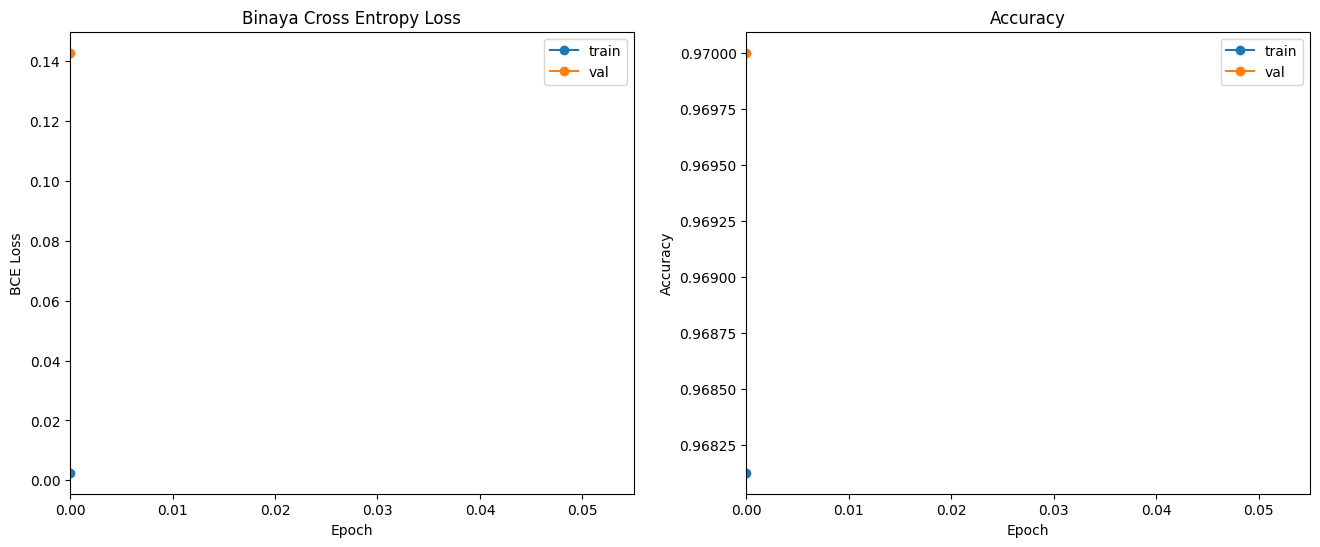

In [96]:
# plot loss/acc for train/val phase
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].plot(train_loss, label='train', marker='o')
ax[1].plot(train_acc, label='train', marker='o')
ax[0].plot(valid_loss, label='val', marker='o')
ax[1].plot(valid_acc, label='val', marker='o')
    
ax[0].set_xlabel('Epoch'); ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('BCE Loss'); ax[1].set_ylabel('Accuracy')
ax[0].set_title(f'Binaya Cross Entropy Loss'); ax[1].set_title('Accuracy')
    
ax[0].set_xlim(0,); ax[1].set_xlim(0,)
ax[0].legend(); ax[1].legend()
plt.show()